![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# PSP data explorer and loader

*flowTorch* supports loading and exploration of [pressure sensitive paint](https://www.dlr.de/as/en/desktopdefault.aspx/tabid-183/251_read-13334/) (PSP) data in the format provided by DLR (Deutsches Luft- und Raumfahrtzentrum). This notebook demonstrates how to explore and visualize instationary PSP (iPSP) data, which are part of the *flowTorch* test datasets. Note that due to confidentiality agreements, the current test data including the corresponding geometry are synthetically generated and do not represent real PSP data.

In [1]:
import torch as pt
import matplotlib.pyplot as plt
import matplotlib as mpl
from flowtorch import DATASETS
from flowtorch.data import PSPDataloader
from flowtorch.analysis import PSPExplorer

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160
# use Latex rendering for math
mpl.rcParams['text.usetex'] = True

## PSP data loader

The iPSP data are provided as [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) binary files. The `PSPDataloader` class enables easy access to both field and meta data. Within an iPSP dataset, there may be multiple zones representing different measurement regions (e.g. different areas on the wing or the horizontal tail plane). Each zone has its own vertices, weights, meta data, and fields.

In [2]:
loader = PSPDataloader(DATASETS["ipsp_fake.hdf5"])
print(f"List of available zones: {loader.zone_names}")

List of available zones: ['Zone0000', 'Zone0001']


Two types of meta data are available. The `info` property returns general information that apply to all zones, e.g., the free stream temperature or the Mach number of the experiment. The `zone_info` property provides information specific to the currently selected zone. Both properties return dictionaries whose values are always tuples of the actual value and an additional description. For example, the value for the key *SamplingFrequency* is a tuple containing the frequency, *10.0*, and its unit *frequency in Hz*.

In [3]:
print(loader.info)
print(loader.zone_info)

{'AngleAttackAlpha': (3.0, 'angle in degrees'), 'Mach': (0.9, 'Mach number')}
{'SamplingFrequency': (10.0, 'frequency in Hz'), 'ZoneName': ('UpperSide', 'name of the zone')}


We can change the currently selected zone by setting the `zone` property.

In [4]:
loader.zone = "Zone0001"
print(f"Currently select zone: {loader.zone}")
print("More descriptive zone name: {:s}".format(loader.zone_info["ZoneName"][0]))

Currently select zone: Zone0001
More descriptive zone name: LowerSide


The remaining properties of the `PSPDataloader` are the same as for all data loaders, e.g., snapshot times, vertices, or weights. The weights represent a binary mask that indicates points with invalid data, e.g., points in the recorded image not covered with pressure sensitive paint (pressure sensors, screws, etc.). The test dataset contains only valid points, but we create a modified mask to demonstrate how further points can be removed if needed. The weights tensor has the same shape as the surface field.

In [5]:
weights = loader.weights
print(f"Shape of weight tensor: {tuple(weights.shape)}")
print(f"Average weight: {weights.mean().item()}")

Shape of weight tensor: (50, 20)
Average weight: 1.0


Since the PSP data is based on recorded images, pressure data are stored as 2D tensors. Visualization and other analysis steps sometimes require to flatten these tensors.

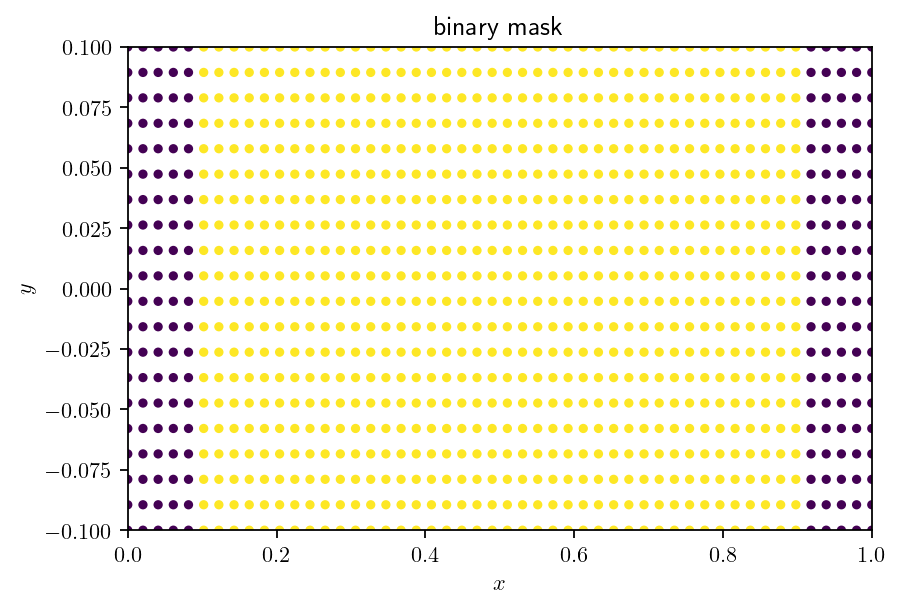

In [6]:
# set the first and the last 5 points along the x-coordinate to zero
# points close to the edges of real data often contain spurious values
weights[:5, :] = 0.0
weights[-5:, :] = 0.0
x = loader.vertices[:, :, 0].flatten()
y = loader.vertices[:, :, 1].flatten()

fig, ax = plt.subplots()
ax.scatter(x, y, c=weights.flatten(), s=10)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_title("binary mask")
plt.show()

As final step in this section, we plot the temporal mean of the pressure coefficient $c_p$ as a filled contour plot. Before computing the mean, we also apply the mask to each snapshot. We emphasize again that the test data does not contain meaningful pressure coefficients.

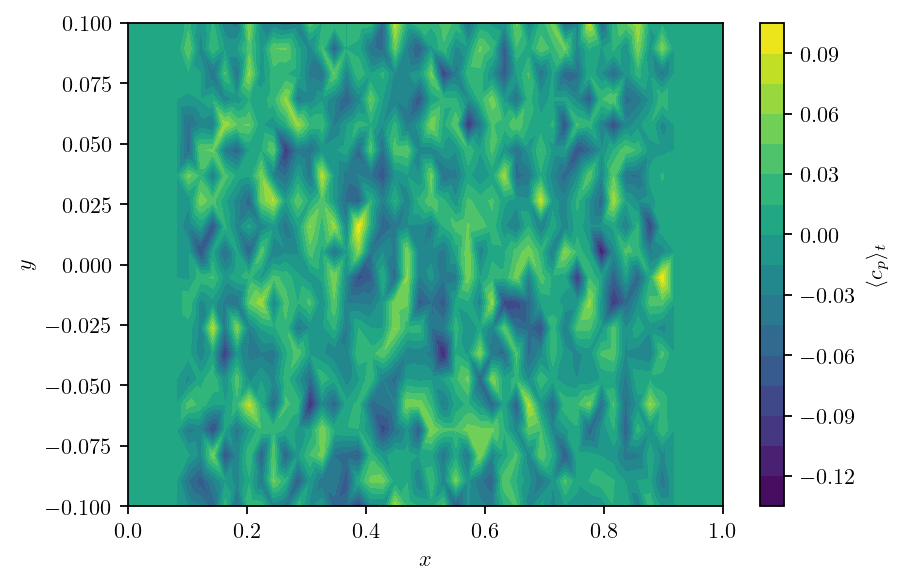

In [7]:
times = loader.write_times
cp_mean = (loader.load_snapshot("Cp", times) * weights.unsqueeze(-1)).mean(dim=-1).flatten()

fig, ax = plt.subplots()
tri = ax.tricontourf(x, y, cp_mean, levels=15)
cbar = plt.colorbar(tri, ax=ax, label=r"$\langle c_p\rangle_t$")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
plt.show()

## PSP data explorer

One aspect we have ignored so far is that the sample surface is usually not flat but curved. The `PSPExlorer` class visualizes the true surface and allows investigating the PSP data interactively. The explorer also creates a dataloader instance, which can be accessed via the `loader` property. 

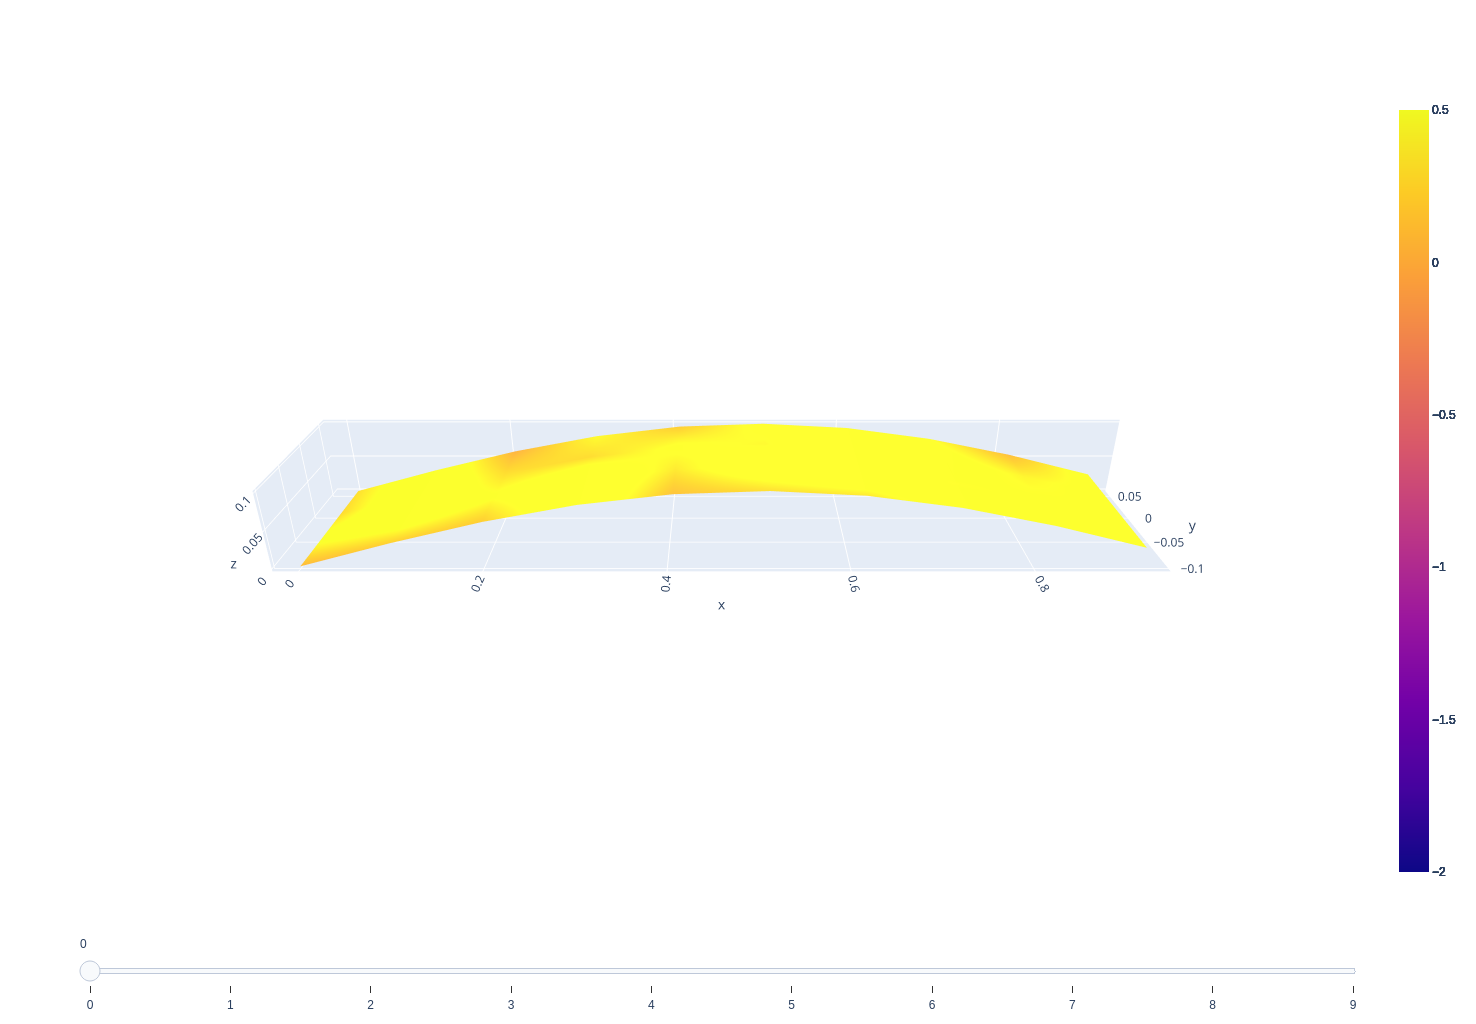

In [8]:
explorer = PSPExplorer(DATASETS["ipsp_fake.hdf5"])
times = explorer.loader.write_times
explorer.interact("Zone0000", "Cp", times[:10])

Oftentimes, a sensible first step in the data analysis is to inspect temporal mean and standard deviation of a field.

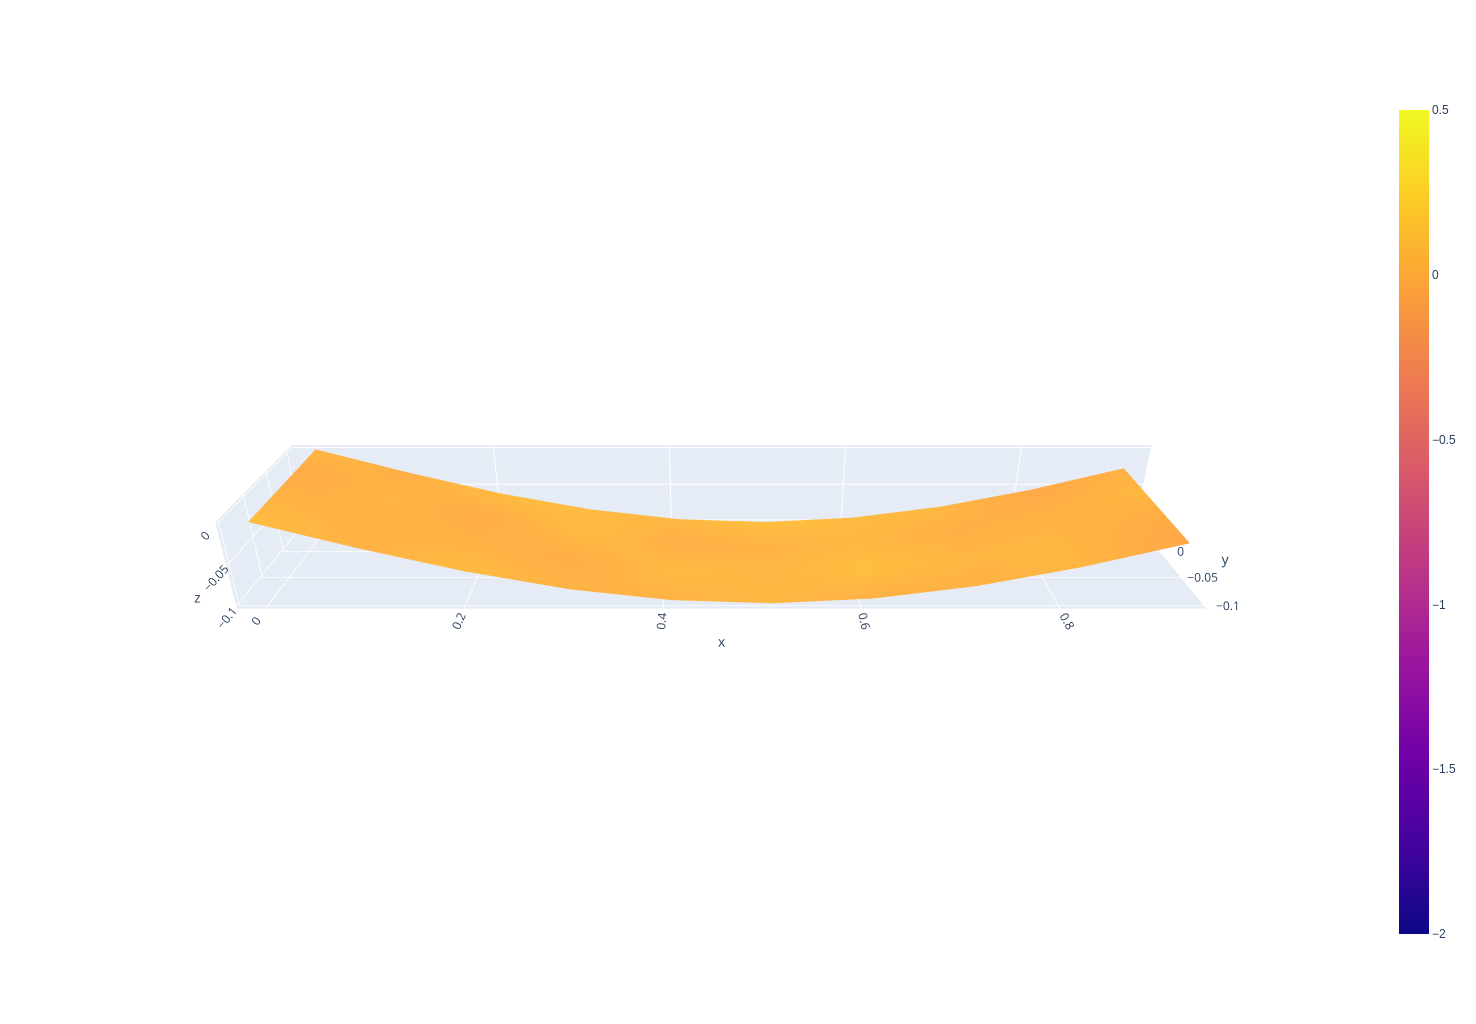

In [9]:
explorer.mean("Zone0001", "Cp", times)

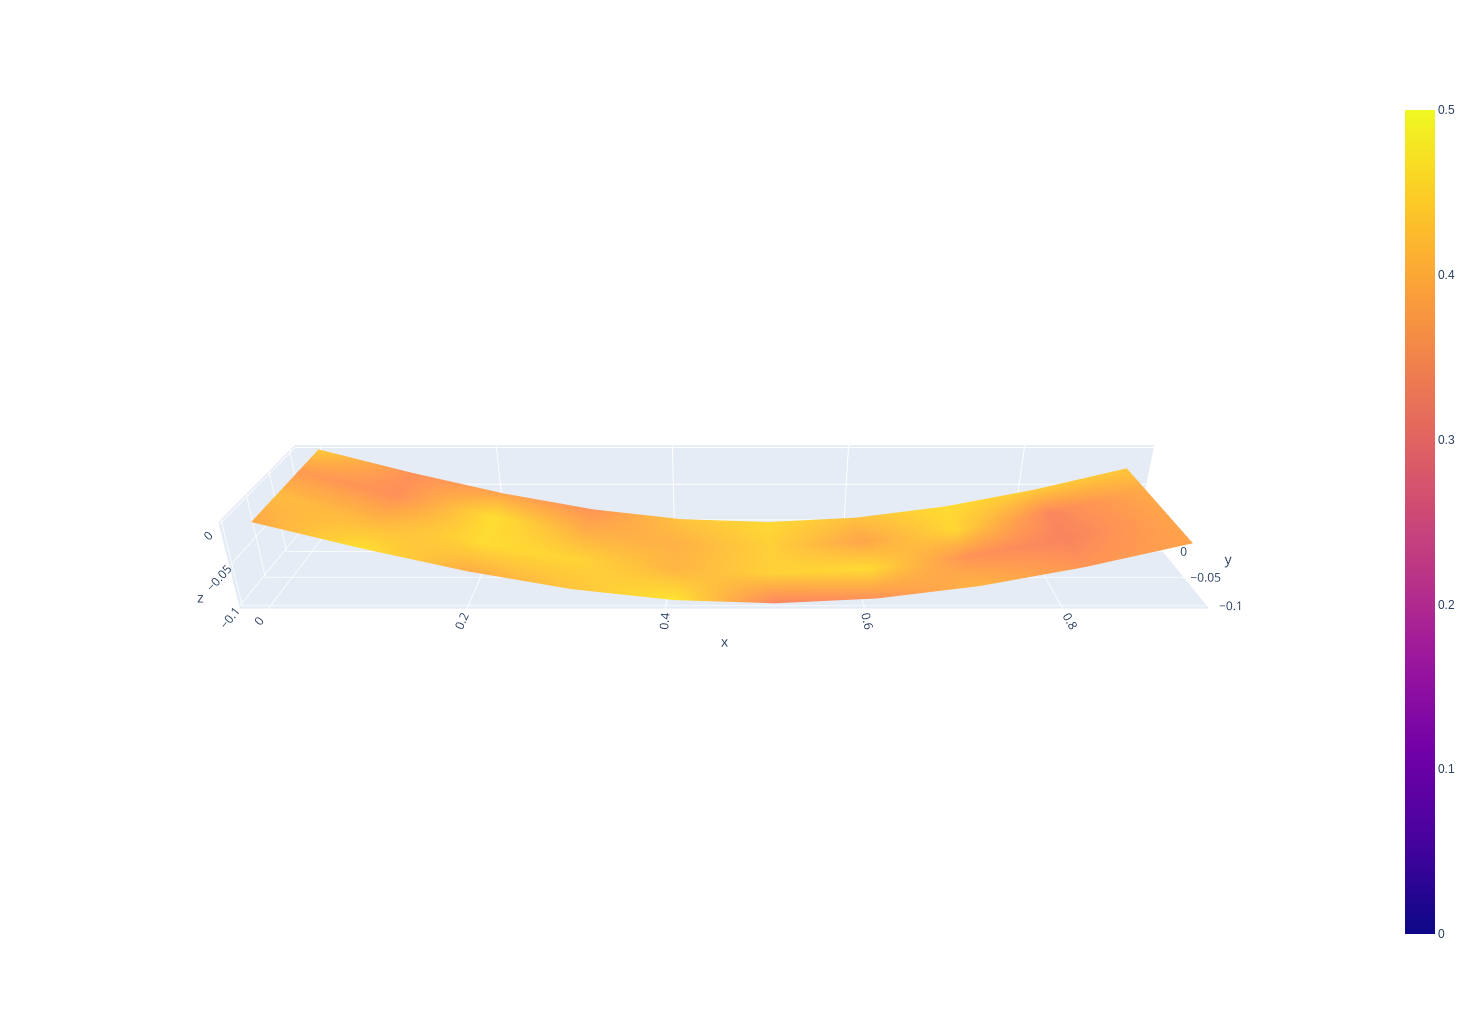

In [10]:
explorer.std("Zone0001", "Cp", times)